In [1]:
path_to_repo = "./sample_java_repo/csc-java-course-spring-2023-key-value-store-EgorShibaev/"

In [2]:
import os
import re

def extract_all_methods_from_repo(path_to_repo):
    """
    Extracts all methods from the file content
    :param path_to_repo: string
    :return: list of strings
    """

    methods_in_repo = {}

    path_to_files = os.path.join(path_to_repo, "src", "main", "java")

    # walk through the files
    for root, dirs, files in os.walk(path_to_files):
        for file in files:
            if file.endswith(".java"):
                # read the file
                with open(os.path.join(root, file), "r", encoding="utf8") as f:
                    file_content = f.read()

                # extract all methods
                methods = extract_all_methods_from_file(file_content)

                if len(methods) > 0:
                    methods_in_repo[file] = methods

    return methods_in_repo


def extract_all_methods_from_file(file_content):
    """
    Extracts all methods from the file content
    :param file_content: string
    :return: list of strings
    """

    # regex for method extraction
    method_pattern = re.compile(r"(public|private|protected)?\s+\b(?!record\b|class\b)[\w<>(\[\])]+\s+([^\s]+)\s*\([^\)]*\)(\s*throws\s+[\w,]+)?\s*\{")
    # extract all methods
    matches = re.finditer(method_pattern, file_content)

    result = []
    for match in matches:
        open_braces = 0
        method_start = match.span()[0]
        method_end = -1

        for i in range(method_start, len(file_content)):
            if file_content[i] == "{":
                open_braces += 1
            elif file_content[i] == "}":
                open_braces -= 1
                if open_braces == 0:
                    method_end = i + 1
                    break

        if method_end == -1:
            raise ValueError(f"Method {match.group()} code extraction failed")

        result.append(file_content[method_start:method_end])

    return result

In [3]:
methods_in_files = extract_all_methods_from_repo(path_to_repo) 

In [4]:
for file, methods in methods_in_files.items():
    print(f"File: {file}")
    print("Nuber of methods: ", len(methods))

File: ByteWrapper.java
Nuber of methods:  5
File: FileBlockLocation.java
Nuber of methods:  2
File: IndexManagerImplementation.java
Nuber of methods:  5
File: KeyValueStoreFactory.java
Nuber of methods:  2
File: KeyValueStoreImplementation.java
Nuber of methods:  9
File: ValueStoreManagerImplementation.java
Nuber of methods:  7


In [5]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")
model = AutoModel.from_pretrained("microsoft/CodeGPT-small-java-adaptedGPT2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
X = [tokenizer(method, return_tensors='pt') for _, methods in methods_in_files.items() for method in methods]
y = [i for i, (_, methods) in enumerate(methods_in_files.items()) for _ in range(len(methods))]

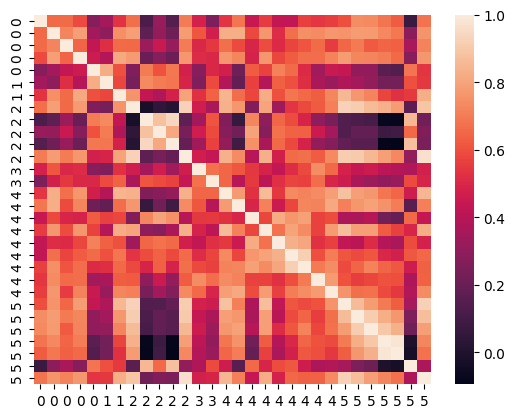

In [7]:
from torch.nn.functional import cosine_similarity

def show_heatmap(X, y, model):
    embeddings = [
        model(**(X[i])).last_hidden_state.mean(dim=1) for i in range(len(X))
    ]

    similarities = [
        [cosine_similarity(emb1, emb2).item() for emb2 in embeddings] for emb1 in embeddings
    ]

    # show the similarity matrix as a heatmap
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(similarities, xticklabels=y, yticklabels=y)
    plt.show()

show_heatmap(X, y, model)

In [8]:
import torch
from torch.nn.functional import cosine_similarity
from torch.nn.functional import binary_cross_entropy
from tqdm.notebook import tqdm

opt = torch.optim.Adam(model.parameters(), lr=1e-5)
epochs = 20

for epoch in tqdm(range(epochs)):

    embeddings = [
        model(**(X[i])).last_hidden_state.mean(dim=1) for i in range(len(X))
    ]

    loss = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            similarity = (cosine_similarity(embeddings[i], embeddings[j]) + 1) / 2 # normalize to [0, 1]
            # since similarity is in [0, 1], we can use binary cross entropy
            loss += binary_cross_entropy(similarity, torch.tensor([float(y[i] == y[j])]))

    loss /= len(embeddings) * (len(embeddings) - 1) / 2  # mean value

    opt.zero_grad()
    loss.backward()
    opt.step()

    print(f"Epoch: {epoch}, loss: {loss.item()}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, loss: 1.3307825326919556
Epoch: 1, loss: 1.2759466171264648
Epoch: 2, loss: 1.1624560356140137
Epoch: 3, loss: 1.0767062902450562
Epoch: 4, loss: 1.0472286939620972
Epoch: 5, loss: 1.0228869915008545
Epoch: 6, loss: 0.9876932501792908
Epoch: 7, loss: 0.9532400369644165
Epoch: 8, loss: 0.9296478033065796
Epoch: 9, loss: 0.9147548675537109
Epoch: 10, loss: 0.8999716639518738
Epoch: 11, loss: 0.8804500102996826
Epoch: 12, loss: 0.8579790592193604
Epoch: 13, loss: 0.836854875087738
Epoch: 14, loss: 0.8193376660346985
Epoch: 15, loss: 0.8043376207351685
Epoch: 16, loss: 0.7892301082611084
Epoch: 17, loss: 0.7724502682685852
Epoch: 18, loss: 0.7545594573020935
Epoch: 19, loss: 0.7373220920562744


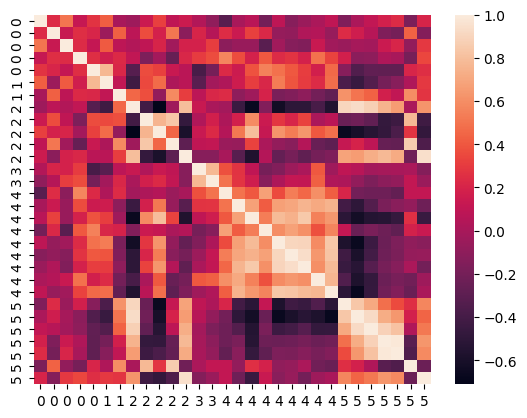

In [9]:
show_heatmap(X, y, model)

We can see that, at average, similarity between methods in one file increased and similarity between methods in different files decreased. 

In [10]:
!jupyter nbconvert --to html task2.ipynb

[NbConvertApp] Converting notebook task2.ipynb to html
[NbConvertApp] Writing 678161 bytes to task2.html
